In [2]:
import logging
# Suppress PyPSA INFO messages (keep warnings and errors)
logging.getLogger('pypsa').setLevel(logging.WARNING)

import pypsa
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces

import gc
import psutil
import matplotlib.pyplot as plt

import neptune

from torch.utils.data import TensorDataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

import os
#import ipdb

[neptune] [warning] NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs-legacy.neptune.ai/setup/upgrading/


In [ ]:
def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

MOST IMPORTANT RESULT DIRECTLY BELOW: we can neglect line flow constraints

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def collect_line_flow_data(network_file, test_snapshots=None, seed=42, save_to_csv=True, csv_filename=None, **env_kwargs):
    """
    Collect detailed line flow data to verify constraint violations.
    Returns DataFrame with p0, s_max, and violation status for each line and scenario.
    
    Parameters:
    -----------
    network_file : str
        Path to network file
    test_snapshots : list, optional
        Snapshots to test. If None, uses all snapshots
    seed : int
        Random seed
    save_to_csv : bool
        Whether to save results to CSV file
    csv_filename : str, optional
        Name of CSV file. If None, auto-generates based on timestamp
    **env_kwargs : dict
        Additional environment kwargs
    
    Returns:
    --------
    pd.DataFrame : Detailed line flow data
    """
    
    # Create environment
    env = EnvDispatchConstr(
        network_file=network_file, 
        no_convergence_lpf_penalty=0,
        reward_scale_factor=1,
        seed=seed,
        **env_kwargs
    )
    
    # If no test snapshots specified, use subset for faster testing
    if test_snapshots is None:
        test_snapshots = env.network.snapshots
    
    line_data = []
    
    print(f"Collecting line flow data for {len(test_snapshots)} snapshots...")
    print(f"Network has {len(env.network.lines)} lines")
    
    for i, snapshot in enumerate(test_snapshots):
        try:
            # Reset environment
            env.reset(seed=seed + i)
            env.snapshot_idx = env.network.snapshots.get_loc(snapshot)
            
            # Test different action scenarios
            scenarios = {
                'random_balanced': np.random.RandomState(seed + i).uniform(0.4, 0.6, env.action_space.shape[0]),
                'random_extreme': np.random.RandomState(seed + i*2).choice([0.1, 0.9], env.action_space.shape[0]),
                'min_generation': np.zeros(env.action_space.shape[0]),
                'max_generation': np.ones(env.action_space.shape[0]),
                'mid_generation': np.full(env.action_space.shape[0], 0.5),
            }
            
            for scenario_name, action in scenarios.items():
                try:
                    # Take action
                    env.take_action(action)
                    
                    # Run power flow
                    current_snapshot = env.network.snapshots[env.snapshot_idx]
                    env.network.lpf(current_snapshot, skip_pre=True)
                    
                    # Collect data for each line
                    for line_name in env.network.lines.index:
                        # Get line parameters
                        s_nom = env.network.lines.loc[line_name, 's_nom']
                        s_max_pu = 1.0  # Default
                        s_max = s_max_pu * s_nom
                        
                        # Get actual power flow
                        p0 = abs(env.network.lines_t.p0.loc[current_snapshot, line_name])
                        
                        # Calculate violation
                        violation = max(0, (p0 - s_max) / s_max) if s_max > 0 else 0
                        is_violated = p0 > s_max
                        
                        # Store data
                        line_data.append({
                            'snapshot': snapshot,
                            'snapshot_idx': i,
                            'scenario': scenario_name,
                            'line_name': line_name,
                            'p0_flow': p0,
                            's_max_limit': s_max,
                            's_nom': s_nom,
                            'utilization_ratio': p0 / s_max if s_max > 0 else 0,
                            'violation_amount': violation,
                            'is_violated': is_violated,
                            'flow_over_limit': p0 - s_max
                        })
                        
                except Exception as e:
                    print(f"Failed scenario {scenario_name} at snapshot {i}: {e}")
                    continue
                    
        except Exception as e:
            print(f"Failed snapshot {i}: {e}")
            continue
            
        if (i + 1) % 10 == 0:
            print(f"Completed {i + 1}/{len(test_snapshots)} snapshots...")
    
    # Convert to DataFrame
    df = pd.DataFrame(line_data)
    
    # Save to CSV if requested
    if save_to_csv:
        if csv_filename is None:
            # Auto-generate filename with timestamp
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            csv_filename = f"detailed_line_flow_data_{timestamp}.csv"
        
        df.to_csv(csv_filename, index=False)
        print(f"\n✓ Data saved to: {csv_filename}")
        print(f"  Total records: {len(df)}")
        print(f"  File size: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    return df

def load_and_plot_line_data(csv_filename):
    """
    Convenience function to load CSV and create plots.
    
    Parameters:
    -----------
    csv_filename : str
        Path to the detailed line flow CSV file
    
    Returns:
    --------
    tuple : (DataFrame, matplotlib.figure.Figure)
    """
    
    print(f"Loading data from: {csv_filename}")
    
    # Load data
    line_data = pd.read_csv(csv_filename)
    
    # Ensure boolean column is correct type
    line_data['is_violated'] = line_data['is_violated'].astype(bool)
    
    print(f"Loaded {len(line_data)} records")
    print(f"Data covers {line_data['snapshot'].nunique()} snapshots, "
          f"{line_data['scenario'].nunique()} scenarios, "
          f"{line_data['line_name'].nunique()} lines")
    
    # Create plots
    fig = plot_line_flow_analysis(line_data)
    
    return line_data, fig

# Example usage:
"""
# Collect data and save to CSV
line_data = collect_line_flow_data(
    network_file_path, 
    test_snapshots=env.network.snapshots[:100],  # Test subset
    csv_filename="my_line_flow_analysis.csv"
)

# Print summary
print_line_flow_summary(line_data)

# Create and save plots
fig = plot_line_flow_analysis(line_data)
fig.savefig('line_flow_analysis.png', dpi=300, bbox_inches='tight')

# Alternative: Load from existing CSV and plot
line_data, fig = load_and_plot_line_data("my_line_flow_analysis.csv")
fig.savefig('line_flow_analysis_from_csv.png', dpi=300, bbox_inches='tight')
"""

'\n# Collect data and save to CSV\nline_data = collect_line_flow_data(\n    network_file_path, \n    test_snapshots=env.network.snapshots[:100],  # Test subset\n    csv_filename="my_line_flow_analysis.csv"\n)\n\n# Print summary\nprint_line_flow_summary(line_data)\n\n# Create and save plots\nfig = plot_line_flow_analysis(line_data)\nfig.savefig(\'line_flow_analysis.png\', dpi=300, bbox_inches=\'tight\')\n\n# Alternative: Load from existing CSV and plot\nline_data, fig = load_and_plot_line_data("my_line_flow_analysis.csv")\nfig.savefig(\'line_flow_analysis_from_csv.png\', dpi=300, bbox_inches=\'tight\')\n'

Generated line_flow_constraint_analysis.csv by running (in online notebook) the cell below

In [ ]:
network_file_path='networks_1_year_connected/elec_s_10_ec_lc1.0_1h.nc'
line_data = collect_line_flow_data(
    network_file_path, 
    csv_filename="line_flow_constraint_analysis.csv"
)

Loading data from: line_flow_constraint_analysis.csv
Loaded 832200 records
Data covers 8760 snapshots, 5 scenarios, 19 lines


/var/folders/tt/b5q5vkxj6xvf2b6q1f46ytgw0000gn/T/ipykernel_61226/1029136066.py:136: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(scenario_data, labels=line_df['scenario'].unique(), patch_artist=True)
/var/folders/tt/b5q5vkxj6xvf2b6q1f46ytgw0000gn/T/ipykernel_61226/1029136066.py:192: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


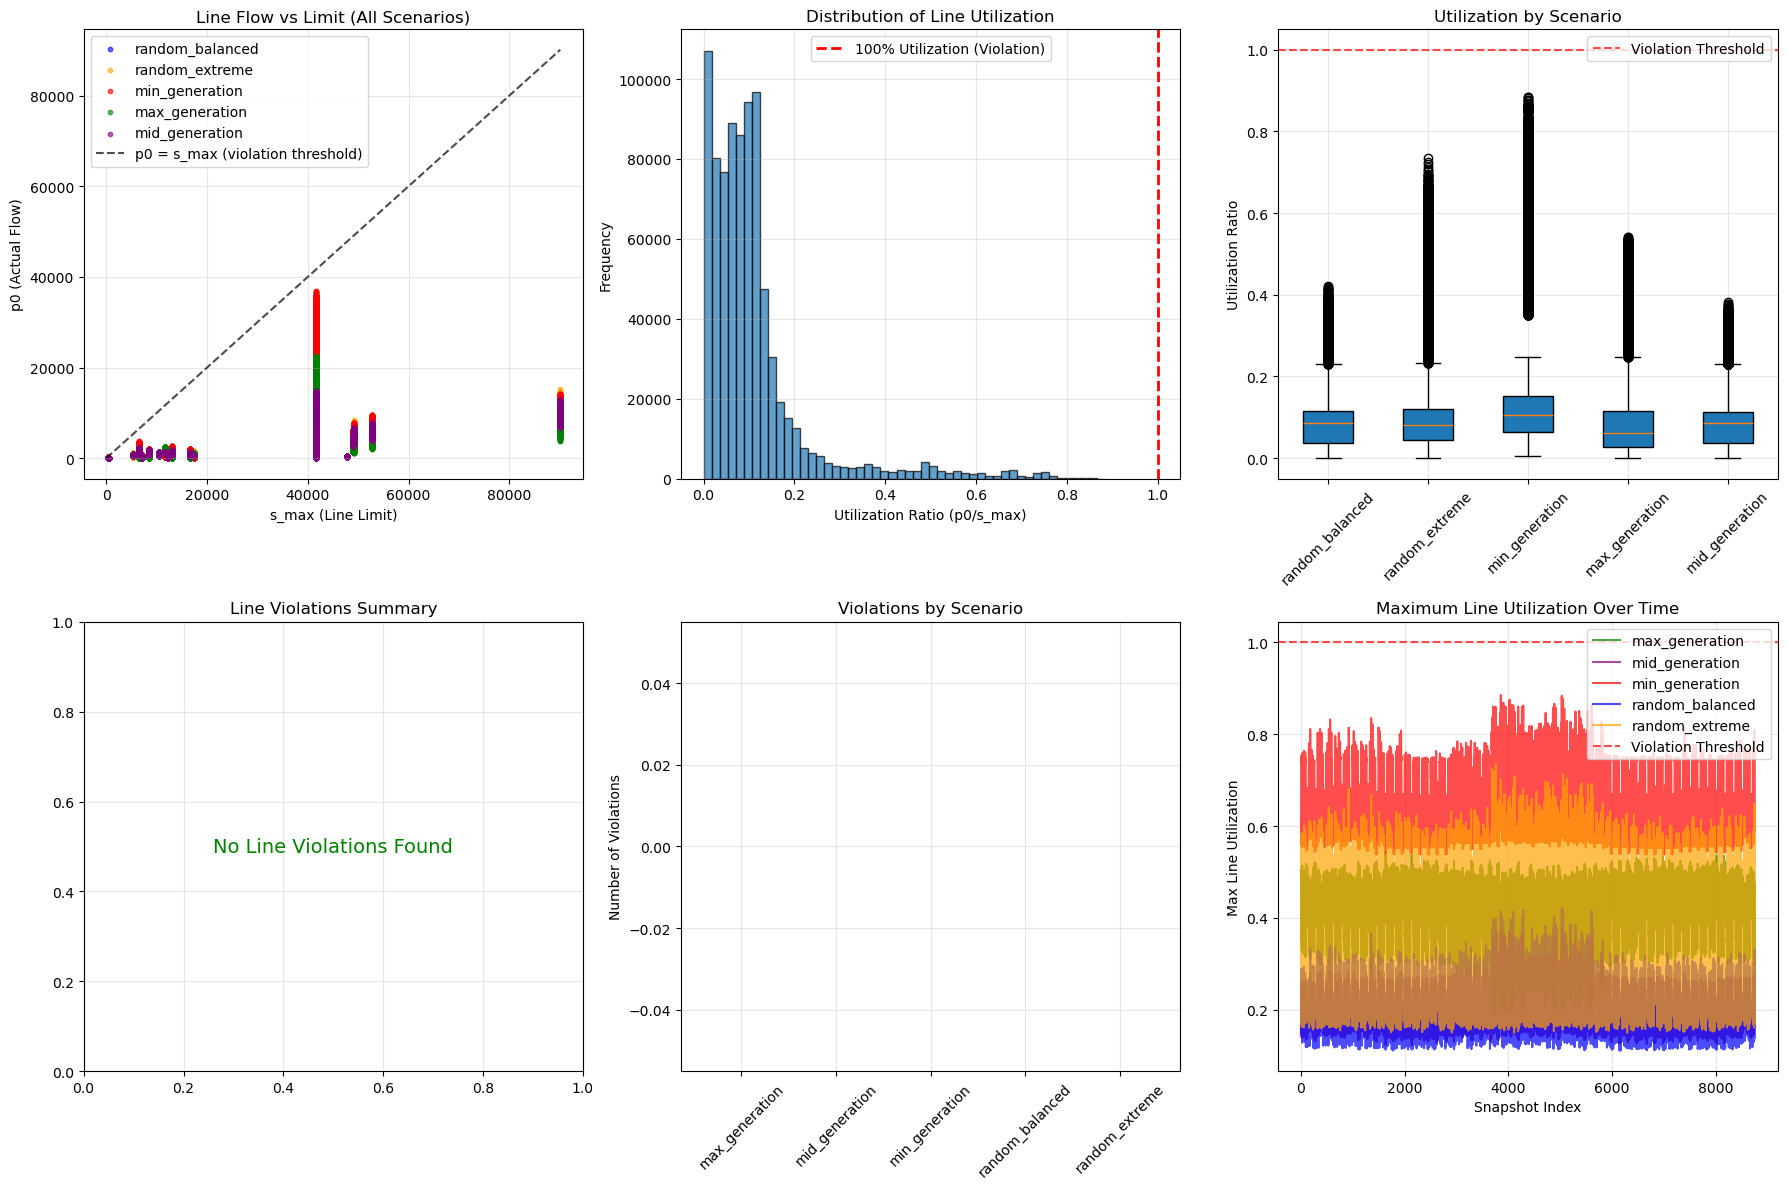

In [ ]:
#load the csv generated in other notebook
line_data, fig = load_and_plot_line_data("line_flow_constraint_analysis.csv")
fig.savefig('line_flow_constraint_analysis.png', dpi=300, bbox_inches='tight')

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_line_utilization_scatter(line_data_df, max_lines_to_show=20, figsize=(16, 10), 
                                 jitter_amount=0.1, alpha=0.6, dpi=300):
    """
    Create high-resolution scatter plots showing all utilization ratios for each transmission line
    (aggregated across all scenarios), with mean and standard deviation overlaid.
    
    Parameters:
    -----------
    line_data_df : pandas.DataFrame
        DataFrame from collect_line_flow_data() with columns:
        'line_name', 'scenario', 'p0_flow', 's_max_limit', 'utilization_ratio', etc.
    max_lines_to_show : int
        Maximum number of lines to show (shows highest capacity lines)
    figsize : tuple
        Figure size in inches
    jitter_amount : float
        Amount of horizontal jitter to add for visibility (0.0 to 0.4)
    alpha : float
        Transparency of scatter points (0.0 to 1.0)
    dpi : int
        Dots per inch for high resolution (300 for publication quality, 150 for screen)
    """
    
    # Set high DPI for better resolution
    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams['savefig.dpi'] = dpi
    
    # Improve font rendering and sizes
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['font.family'] = 'DejaVu Sans'  # Use a clean font
    
    # Select lines to show (top N by capacity)
    line_capacities = line_data_df.groupby('line_name')['s_max_limit'].first().sort_values(ascending=False)
    lines_to_show = line_capacities.head(max_lines_to_show).index.tolist()
    
    # Filter data
    plot_data = line_data_df[line_data_df['line_name'].isin(lines_to_show)].copy()
    
    # Create figure with higher resolution
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    
    # Create x-axis positions for each line
    x_positions = np.arange(len(lines_to_show))
    line_x_map = dict(zip(lines_to_show, x_positions))
    
    # Plot all individual points with improved styling
    for line_name in lines_to_show:
        line_data = plot_data[plot_data['line_name'] == line_name]
        
        if len(line_data) > 0:
            x_base = line_x_map[line_name]
            # Add small random jitter for visibility
            x_jittered = x_base + np.random.normal(0, jitter_amount, len(line_data))
            y_values = line_data['utilization_ratio'].values
            
            ax.scatter(x_jittered, y_values, 
                      color='steelblue', 
                      alpha=alpha, 
                      s=25,  # Slightly larger points
                      edgecolors='navy', 
                      linewidth=0.5,  # Thicker edge
                      rasterized=True)  # Better rendering for many points
    
    # Calculate and plot mean with standard deviation error bars
    means = []
    stds = []
    line_names_for_stats = []
    
    for line_name in lines_to_show:
        line_data = plot_data[plot_data['line_name'] == line_name]
        if len(line_data) > 0:
            mean_util = line_data['utilization_ratio'].mean()
            std_util = line_data['utilization_ratio'].std()
            means.append(mean_util)
            stds.append(std_util)
            line_names_for_stats.append(line_name)
    
    # Plot means with improved error bars
    ax.errorbar(x_positions[:len(means)], means, yerr=stds, 
                fmt='o', color='crimson', markersize=10, capsize=6, capthick=2.5,
                ecolor='crimson', elinewidth=2.5, markeredgecolor='darkred', 
                markeredgewidth=1.5, label='Mean ± Std Dev', zorder=10,
                alpha=0.9)
    
    # Add horizontal line at 100% utilization with better styling
    ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.8, linewidth=2.5, 
               label='100% Utilization (Violation Threshold)', zorder=5)
    
    # Improved formatting
    ax.set_xlabel('Transmission Line', fontsize=13, fontweight='bold', labelpad=10)
    ax.set_ylabel('Utilization Ratio (|p0|/s_max)', fontsize=13, fontweight='bold', labelpad=10)
    ax.set_title(f'Line Utilization Distribution Across All Data\n({len(plot_data)} data points)', 
                 fontsize=15, fontweight='bold', pad=20)
    
    # Improve x-axis labels
    ax.set_xticks(x_positions[:len(lines_to_show)])
    ax.set_xticklabels([name.replace('_', '\n') for name in lines_to_show], 
                       rotation=45, ha='right', fontsize=10, fontweight='normal')
    
    # Enhanced grid and legend
    ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.8, axis='y')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5, axis='x')
    
    legend = ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11,
                      frameon=True, fancybox=True, shadow=True, framealpha=0.9)
    legend.get_frame().set_facecolor('white')
    
    # Set y-axis limits with padding
    y_max = max(max(means) + max(stds), plot_data['utilization_ratio'].max())
    ax.set_ylim(0, y_max * 1.1)
    
    # Improve spine styling
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('black')
    
    # Adjust layout with more padding
    plt.tight_layout(pad=2.0)
    
    # Option to save high-resolution figure
    # plt.savefig('line_utilization_plot.png', dpi=300, bbox_inches='tight', 
    #             facecolor='white', edgecolor='none')
    
    plt.show()
    
    # Print detailed statistics (unchanged)
    print("=== LINE UTILIZATION ANALYSIS (AGGREGATED) ===")
    total_scenarios = len(plot_data['scenario'].unique())
    print(f"Analyzed {len(lines_to_show)} lines across {total_scenarios} scenarios (aggregated)")
    print(f"Total data points: {len(plot_data)}")
    
    print(f"\n{'Line Name':<20} {'Capacity':<10} {'Samples':<8} {'Mean Util':<10} {'Std Dev':<10} {'Max Util':<10} {'Violations':<12}")
    print("-" * 100)
    
    for i, line_name in enumerate(lines_to_show):
        line_subset = plot_data[plot_data['line_name'] == line_name]
        if len(line_subset) > 0:
            capacity = line_subset['s_max_limit'].iloc[0]
            n_samples = len(line_subset)
            mean_util = line_subset['utilization_ratio'].mean()
            std_util = line_subset['utilization_ratio'].std()
            max_util = line_subset['utilization_ratio'].max()
            n_violations = line_subset['is_violated'].sum()
            violation_pct = (n_violations / n_samples) * 100
            
            print(f"{line_name:<20} {capacity:<10.0f} {n_samples:<8} {mean_util:<10.3f} {std_util:<10.3f} "
                  f"{max_util:<10.3f} {n_violations}/{n_samples} ({violation_pct:.1f}%)")
    
    return means, stds

# Additional helper function for saving high-quality plots
def save_high_quality_plot(filename, dpi=300, format='png', bbox_inches='tight'):
    """
    Save the current plot with high quality settings.
    
    Parameters:
    -----------
    filename : str
        Output filename (without extension)
    dpi : int
        Resolution in dots per inch
    format : str
        File format ('png', 'pdf', 'svg', 'eps')
    bbox_inches : str
        Bounding box setting for tight layout
    """
    plt.savefig(f'{filename}.{format}', 
                dpi=dpi, 
                bbox_inches=bbox_inches,
                facecolor='white', 
                edgecolor='none',
                format=format,
                transparent=False,
                pad_inches=0.2)
    print(f"High-quality plot saved as {filename}.{format} at {dpi} DPI")

# Global settings for consistent high-quality plots
def set_high_quality_defaults():
    """Set matplotlib defaults for high-quality plots."""
    plt.rcParams.update({
        'figure.dpi': 150,           # Screen display DPI
        'savefig.dpi': 300,          # Save DPI
        'font.size': 12,             # Base font size
        'axes.titlesize': 14,        # Title font size
        'axes.labelsize': 12,        # Axis label font size
        'xtick.labelsize': 10,       # X-tick label font size
        'ytick.labelsize': 10,       # Y-tick label font size
        'legend.fontsize': 10,       # Legend font size
        'font.family': 'DejaVu Sans', # Clean font family
        'axes.linewidth': 1.2,       # Axis line width
        'grid.linewidth': 0.8,       # Grid line width
        'lines.linewidth': 2,        # Default line width
        'patch.linewidth': 0.5,      # Patch edge width
        'axes.edgecolor': 'black',   # Axis edge color
        'text.antialiased': True,    # Smooth text rendering
        'figure.autolayout': False,  # Don't auto-adjust layout
        'savefig.bbox': 'tight',     # Tight bounding box when saving
        'savefig.pad_inches': 0.1,   # Padding when saving
    })

# Example usage with high-quality settings:
"""
# Set high-quality defaults
set_high_quality_defaults()

# Load your CSV data
line_data = pd.read_csv('your_line_flow_data.csv')

# Create high-resolution plot
means, stds = plot_line_utilization_scatter(line_data, 
                                          max_lines_to_show=20, 
                                          figsize=(18, 12),  # Larger figure
                                          dpi=300,           # High DPI
                                          jitter_amount=0.08)

# Save high-quality version
save_high_quality_plot('transmission_line_utilization', dpi=300, format='png')

# For publication, you might also want PDF or SVG:
save_high_quality_plot('transmission_line_utilization', dpi=300, format='pdf')
save_high_quality_plot('transmission_line_utilization', dpi=300, format='svg')
"""

"\n# Set high-quality defaults\nset_high_quality_defaults()\n\n# Load your CSV data\nline_data = pd.read_csv('your_line_flow_data.csv')\n\n# Create high-resolution plot\nmeans, stds = plot_line_utilization_scatter(line_data, \n                                          max_lines_to_show=20, \n                                          figsize=(18, 12),  # Larger figure\n                                          dpi=300,           # High DPI\n                                          jitter_amount=0.08)\n\n# Save high-quality version\nsave_high_quality_plot('transmission_line_utilization', dpi=300, format='png')\n\n# For publication, you might also want PDF or SVG:\nsave_high_quality_plot('transmission_line_utilization', dpi=300, format='pdf')\nsave_high_quality_plot('transmission_line_utilization', dpi=300, format='svg')\n"

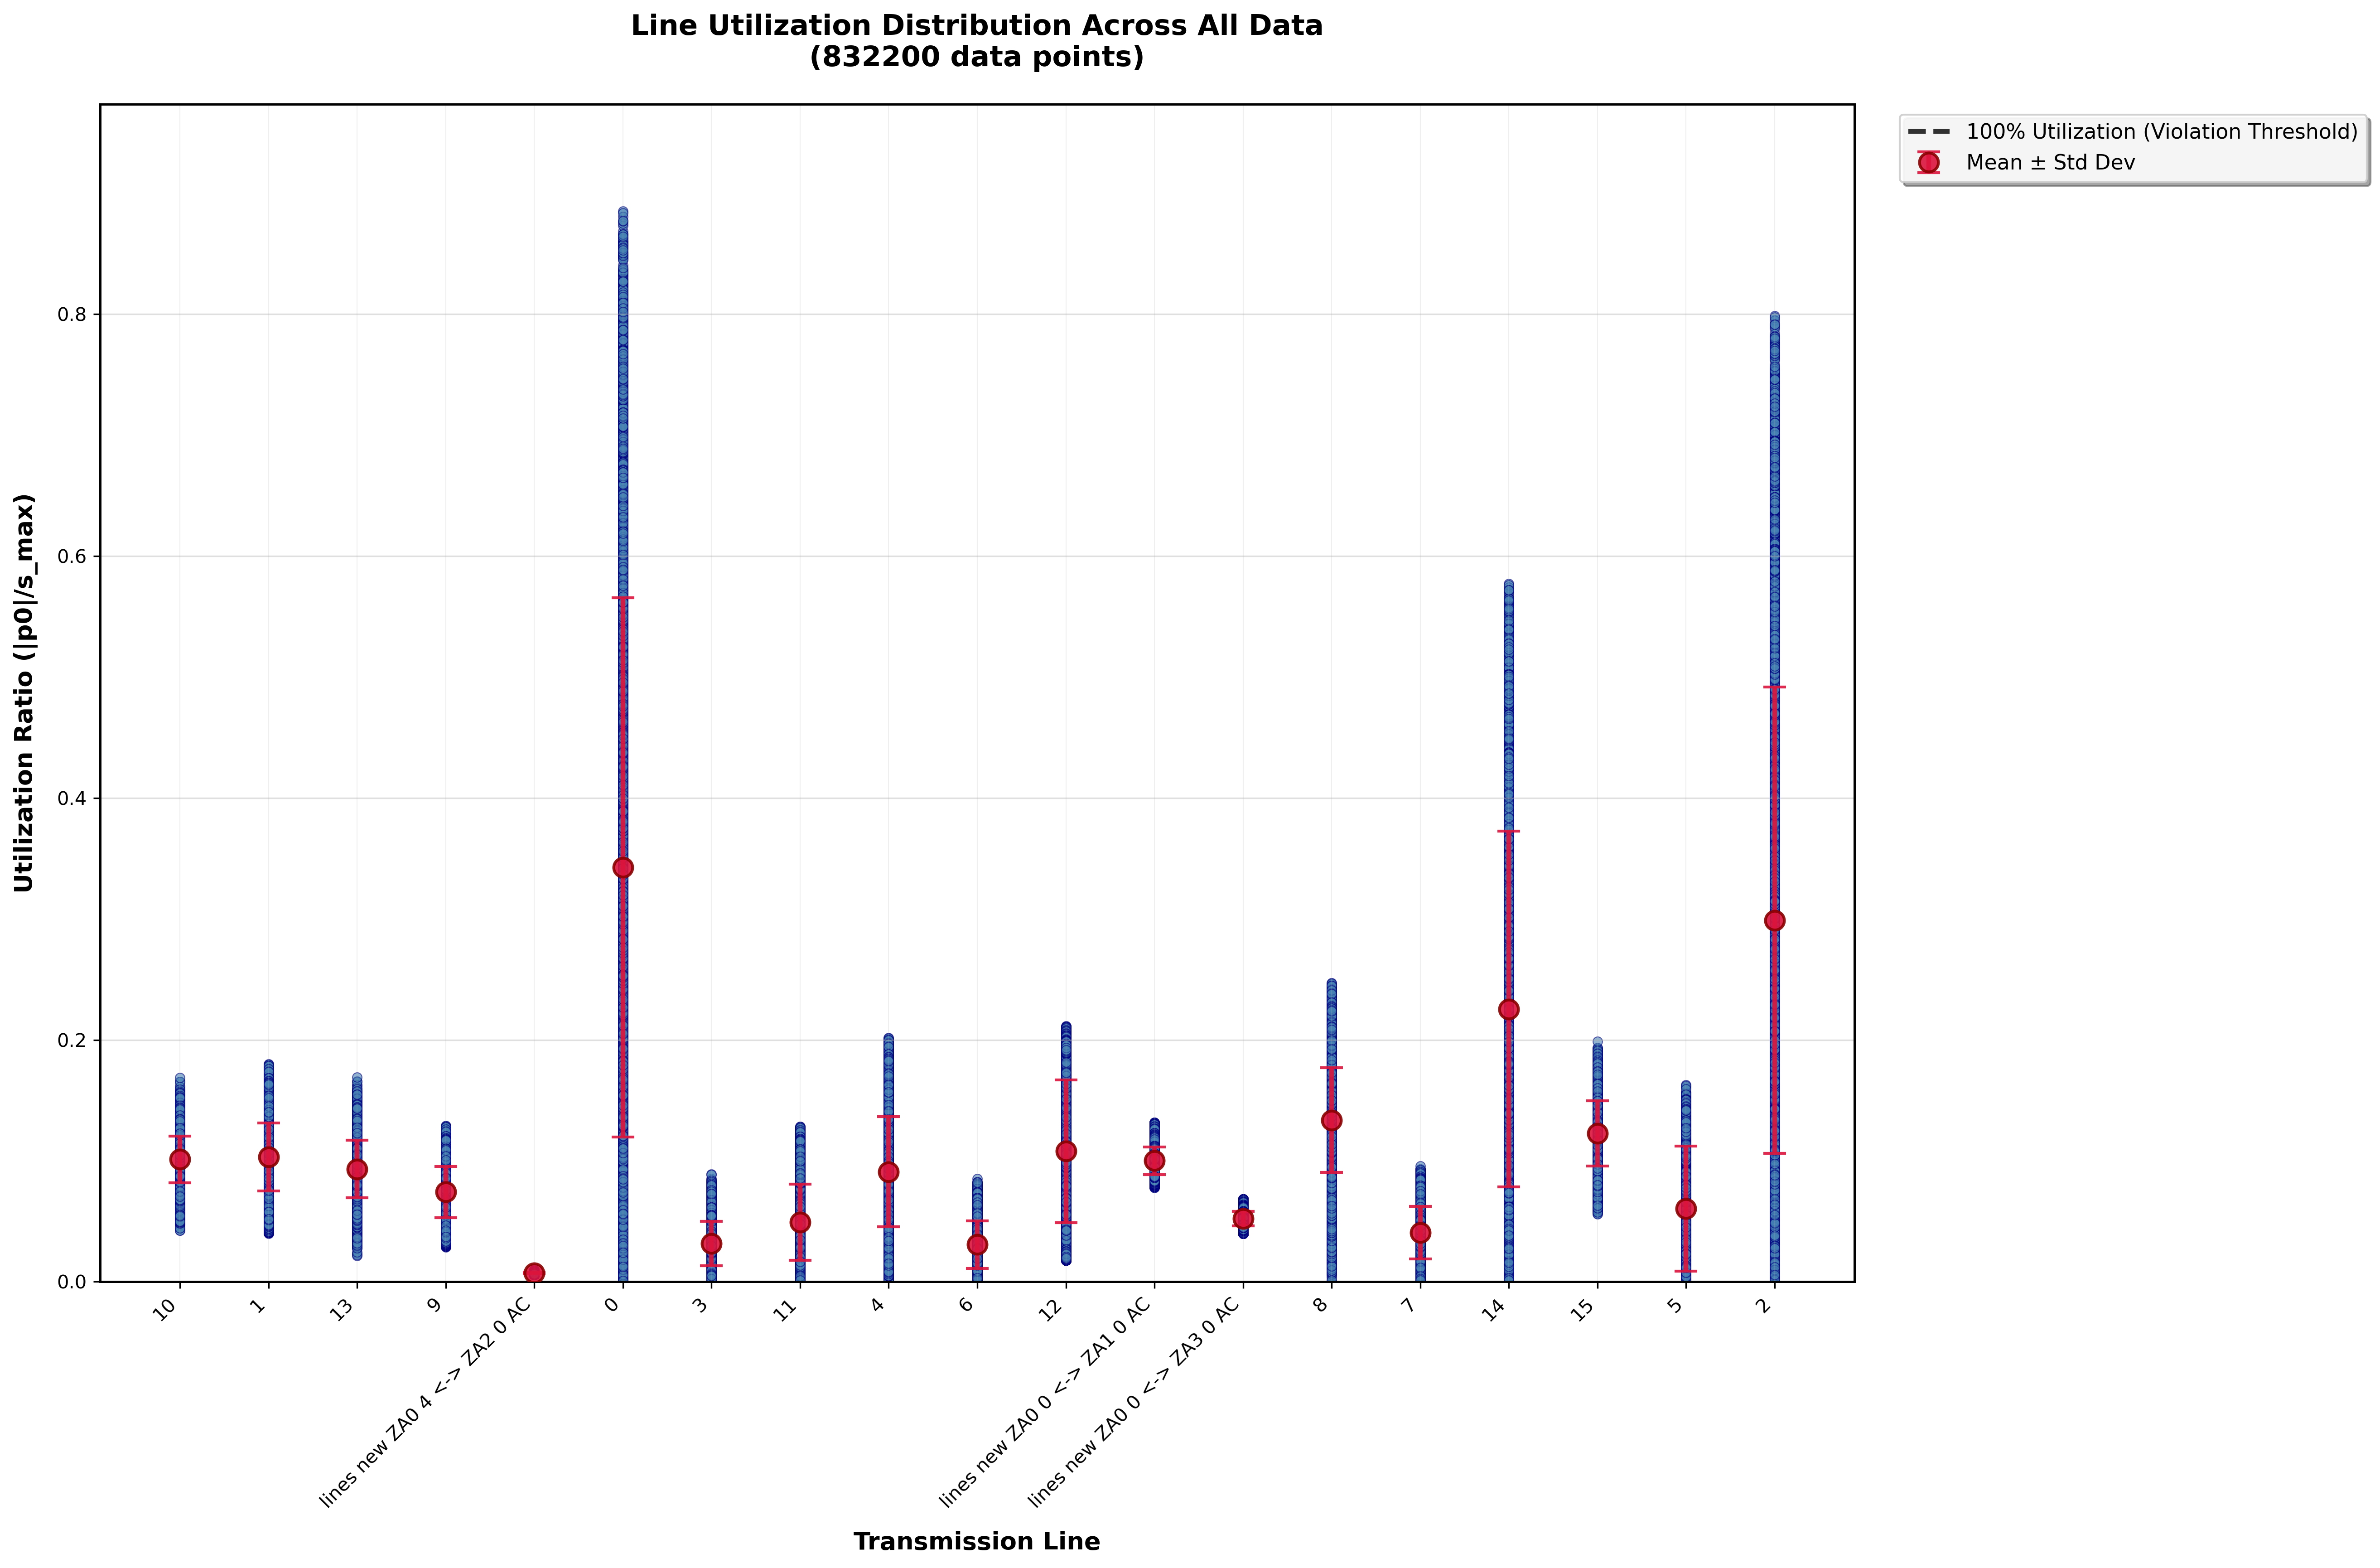

=== LINE UTILIZATION ANALYSIS (AGGREGATED) ===
Analyzed 19 lines across 5 scenarios (aggregated)
Total data points: 832200

Line Name            Capacity   Samples  Mean Util  Std Dev    Max Util   Violations  
----------------------------------------------------------------------------------------------------
10                   90135      43800    0.101      0.019      0.169      0/43800 (0.0%)
1                    52846      43800    0.103      0.028      0.180      0/43800 (0.0%)
13                   49160      43800    0.093      0.024      0.169      0/43800 (0.0%)
9                    48929      43800    0.074      0.021      0.129      0/43800 (0.0%)
lines new ZA0 4 <-> ZA2 0 AC 47837      43800    0.007      0.001      0.009      0/43800 (0.0%)
0                    41678      43800    0.343      0.223      0.885      0/43800 (0.0%)
3                    17414      43800    0.032      0.018      0.089      0/43800 (0.0%)
11                   16536      43800    0.049      0.031

<Figure size 1920x1440 with 0 Axes>

In [32]:
line_data = pd.read_csv("/Users/antoniagrindrod/Documents/pypsa-earth_project/pypsa-earth-RL/RL/line_flow_constraint_analysis.csv")
means, stds = plot_line_utilization_scatter(line_data, 
                                          max_lines_to_show=20, 
                                          figsize=(18, 12),  # Larger figure
                                          dpi=300,           # High DPI
                                          jitter_amount=0)
save_high_quality_plot('transmission_line_utilization', dpi=300, format='png')

In [4]:
def fix_artificial_lines_reasonable(network):
    """
    Fix artificial lines with reasonable capacity values:
    - s_nom = based on connected bus demand (with safety factor)
    - s_nom_extendable = False (non-extendable)
    - Keep capacity high enough to meet demand
    """
    print("=== FIXING ARTIFICIAL LINES WITH REASONABLE CAPACITY ===")

    # Find artificial lines
    artificial_lines = [line for line in network.lines.index
                       if any(keyword in str(line).lower() for keyword in ['new', '<->', 'artificial'])]

    if not artificial_lines:
        # If no artificial lines found by name, look for lines with s_nom=0
        # which is often a sign of artificial lines
        zero_capacity_lines = network.lines[network.lines.s_nom == 0].index.tolist()
        if zero_capacity_lines:
            artificial_lines = zero_capacity_lines

    print(f"Found {len(artificial_lines)} artificial lines to fix:")

    # Get maximum demand per bus across all snapshots
    bus_max_demand = {}
    for bus in network.buses.index:
        bus_demand = 0
        for load_name, load in network.loads.iterrows():
            if load.bus == bus and load_name in network.loads_t.p_set.columns:
                bus_demand = max(bus_demand, network.loads_t.p_set[load_name].max())
        bus_max_demand[bus] = bus_demand

    # Fix each artificial line with reasonable capacity
    for line_name in artificial_lines:
        # Get connected buses
        bus0 = network.lines.loc[line_name, 'bus0']
        bus1 = network.lines.loc[line_name, 'bus1']

        # Get maximum demand at these buses
        bus0_demand = bus_max_demand.get(bus0, 0)
        bus1_demand = bus_max_demand.get(bus1, 0)

        # Calculate required capacity with safety factor
        # Use 3x the higher demand to ensure adequate capacity
        safety_factor = 3.0
        required_capacity = max(bus0_demand, bus1_demand) * safety_factor

        # Ensure minimum reasonable capacity (1000 MW)
        required_capacity = max(required_capacity, 1000)

        print(f"\n Fixing: {line_name}")
        print(f"    Connected buses: {bus0} ↔ {bus1}")
        print(f"    Bus demands: {bus0}: {bus0_demand:.1f} MW, {bus1}: {bus1_demand:.1f} MW")

        # Set s_nom to required capacity
        old_s_nom = network.lines.loc[line_name, 's_nom']
        network.lines.loc[line_name, 's_nom'] = required_capacity
        print(f"    s_nom: {old_s_nom} → {required_capacity:.1f} MW")

        # Make sure line is not extendable
        if 's_nom_extendable' not in network.lines.columns:
            network.lines['s_nom_extendable'] = False
        network.lines.loc[line_name, 's_nom_extendable'] = False
        print(f"    s_nom_extendable: → False")

    return network

def remove_offshore_wind(network):
    """
    Remove offshore wind generators. 
    All of these have zero nominal capacity (likely missing data). 
    Need to remove them to avoid division by zero error in constraint check for slack gens.
    Problem is still feasible without offwind slack since pypsa optimize still feasible.
    """
    
    # First, identify offshore wind generators
    offwind_gens = network.generators[
        network.generators.index.str.contains('offwind', case=False, na=False)
    ].index
    
    print(f"Found {len(offwind_gens)} offshore wind generators:")
    print(offwind_gens.tolist())
    
    # Check their properties
    offwind_data = network.generators.loc[offwind_gens, ['p_nom', 'control', 'carrier']]
    print("\nOffshore wind generator details:")
    print(offwind_data)
    
    # Remove offshore wind generators one by one
    print(f"\nRemoving {len(offwind_gens)} offshore wind generators...")
    for gen in offwind_gens:
        network.remove("Generator", gen)

def create_pypsa_network(network_file):
    """Create a PyPSA network from the .nc file."""
    # Initialize network
    network = pypsa.Network(network_file)
    for storage_name in network.storage_units.index:
        # Use .loc for direct assignment to avoid SettingWithCopyWarning
        network.storage_units.loc[storage_name, 'cyclic_state_of_charge'] = False

        # Set marginal_cost to 0.01
        network.storage_units.loc[storage_name, 'marginal_cost'] = 0.01

        # Set marginal_cost_storage to 0.01
        network.storage_units.loc[storage_name, 'marginal_cost_storage'] = 0.01

        # Set spill_cost to 0.1
        network.storage_units.loc[storage_name, 'spill_cost'] = 0.1

        network.storage_units.loc[storage_name, 'efficiency_store'] = 0.866025 #use phs efficiency (hydro didnt have an efficiency, but i want to model them all as the same)

        # Fix unrealistic max_hours values
        current_max_hours = network.storage_units.loc[storage_name, 'max_hours']

        if 'PHS' in storage_name:
            # PHS with missing data - set to typical range
            network.storage_units.loc[storage_name, 'max_hours'] = 8.0
            print(f"Fixed {storage_name}: set max_hours to 8.0")

        elif 'hydro' in storage_name:
            # Hydro with unrealistic data - set to validated range
            network.storage_units.loc[storage_name, 'max_hours'] = 6.0
            print(f"Fixed {storage_name}: corrected max_hours from {current_max_hours} to 6.0")


    fix_artificial_lines_reasonable(network)
    remove_offshore_wind(network)

    return network

In [41]:
# Use .index to get the actual storage unit names/indices
for storage_unit in network.storage_units.index:
    p_nom = network.storage_units.p_nom[storage_unit]
    p_min_pu = network.storage_units.p_min_pu[storage_unit]
    p_max_pu = network.storage_units.p_max_pu[storage_unit]
    print(storage_unit, ": ", p_nom*p_min_pu, ", ",  p_nom*p_max_pu)

ZA0 0 PHS :  -2332.0 ,  2332.0
ZA0 5 PHS :  -560.0 ,  560.0
ZA0 6 hydro :  0.0 ,  600.0


In [35]:
import pandas as pd
import numpy as np

def get_storage_unit_bounds_all_attrs(n, sns=None):
    """
    Get operational bounds for all StorageUnit attributes.
    
    Parameters:
    -----------
    n : pypsa.Network
        The PyPSA network object
    sns : pd.Index, optional
        Snapshots to consider. If None, uses all snapshots
    
    Returns:
    --------
    dict: Dictionary with bounds for each attribute
    """
    
    if sns is None:
        sns = n.snapshots
    
    storage_units = n.storage_units
    
    if storage_units.empty:
        return {}
    
    # Get fixed vs extendable storage units
    extendable_mask = storage_units.get('p_nom_extendable', pd.Series(False, index=storage_units.index))
    committable_mask = storage_units.get('committable', pd.Series(False, index=storage_units.index))
    inactive_mask = pd.Series(False, index=storage_units.index)  # Assuming no inactive assets
    
    fixed_mask = ~extendable_mask & ~committable_mask & ~inactive_mask
    fix_i = storage_units.index[fixed_mask]
    ext_i = storage_units.index[extendable_mask & ~committable_mask & ~inactive_mask]
    
    results = {}
    
    # Define attribute mappings
    attr_configs = {
        'p_dispatch': {
            'min_pu_col': 'p_min_pu',
            'max_pu_col': 'p_max_pu',
            'nominal_multiplier': 1.0,  # Uses p_nom directly
            'description': 'Power discharge bounds'
        },
        'p_store': {
            'min_pu_col': 'p_min_pu',  # Usually negative for charging
            'max_pu_col': 'p_max_pu',  # Usually zero or positive for charging
            'nominal_multiplier': 1.0,  # Uses p_nom directly
            'description': 'Power charge bounds (note: charging is usually negative)'
        },
        'state_of_charge': {
            'min_pu_col': 'state_of_charge_min_pu',
            'max_pu_col': 'state_of_charge_max_pu', 
            'nominal_multiplier': 'max_hours',  # Uses p_nom * max_hours
            'description': 'State of charge bounds'
        },
        'p_set': {
            'min_pu_col': 'p_min_pu',
            'max_pu_col': 'p_max_pu',
            'nominal_multiplier': 1.0,  # Uses p_nom directly
            'description': 'Net power bounds (p_dispatch - p_store)'
        }
    }
    
    for attr, config in attr_configs.items():
        print(f"\n=== {attr.upper()} - {config['description']} ===")
        
        # Process fixed storage units
        if len(fix_i) > 0:
            fixed_bounds = _get_bounds_for_units(
                storage_units, fix_i, attr, config, is_extendable=False
            )
            if not fixed_bounds.empty:
                results[f'{attr}_fixed'] = fixed_bounds
                print(f"Fixed StorageUnits ({attr}):")
                print(fixed_bounds[['name', 'lower_bound', 'upper_bound', 'nominal']])
        
        # Process extendable storage units  
        if len(ext_i) > 0:
            ext_bounds = _get_bounds_for_units(
                storage_units, ext_i, attr, config, is_extendable=True
            )
            if not ext_bounds.empty:
                results[f'{attr}_extendable'] = ext_bounds
                print(f"Extendable StorageUnits ({attr}):")
                print(ext_bounds[['name', 'min_pu', 'max_pu', 'p_nom_min', 'p_nom_max']])
    
    return results

def _get_bounds_for_units(storage_units, unit_indices, attr, config, is_extendable=False):
    """Helper function to calculate bounds for a set of storage units"""
    
    if len(unit_indices) == 0:
        return pd.DataFrame()
    
    # Get per-unit bounds
    min_pu_col = config['min_pu_col']
    max_pu_col = config['max_pu_col']
    
    # Default values if columns don't exist
    if attr == 'p_store':
        # For p_store, we need to be careful about sign conventions
        # In PyPSA, p_store is typically positive when charging
        # But the bounds might be set differently
        default_min = 0.0  # Can't discharge through store
        default_max = 1.0  # Can charge up to full capacity
    elif attr == 'state_of_charge':
        default_min = 0.0
        default_max = 1.0
    else:  # p_dispatch, p_set
        default_min = 0.0
        default_max = 1.0
    
    min_pu = storage_units.loc[unit_indices, min_pu_col] if min_pu_col in storage_units.columns else pd.Series(default_min, index=unit_indices)
    max_pu = storage_units.loc[unit_indices, max_pu_col] if max_pu_col in storage_units.columns else pd.Series(default_max, index=unit_indices)
    
    # Calculate nominal capacity
    if config['nominal_multiplier'] == 'max_hours':
        nominal = storage_units.loc[unit_indices, 'p_nom'] * storage_units.loc[unit_indices, 'max_hours']
    else:
        nominal = storage_units.loc[unit_indices, 'p_nom'] * config['nominal_multiplier']
    
    if is_extendable:
        # For extendable units, we return per-unit bounds and capacity bounds
        results = pd.DataFrame({
            'name': unit_indices,
            'min_pu': min_pu,
            'max_pu': max_pu,
            'p_nom_min': storage_units.loc[unit_indices, 'p_nom_min'] if 'p_nom_min' in storage_units.columns else 0.0,
            'p_nom_max': storage_units.loc[unit_indices, 'p_nom_max'] if 'p_nom_max' in storage_units.columns else np.inf,
            'max_hours': storage_units.loc[unit_indices, 'max_hours'],
            'extendable': True
        })
    else:
        # For fixed units, calculate absolute bounds
        lower = min_pu * nominal
        upper = max_pu * nominal
        
        results = pd.DataFrame({
            'name': unit_indices,
            'lower_bound': lower,
            'upper_bound': upper,
            'nominal': nominal,
            'min_pu': min_pu,
            'max_pu': max_pu,
            'extendable': False
        })
    
    return results

def analyze_storage_unit_constraints_detailed(n, sns=None):
    """
    Detailed analysis of how PyPSA will constrain each StorageUnit
    """
    
    print("=== STORAGE UNIT CONSTRAINT ANALYSIS ===")
    
    storage_units = n.storage_units
    if storage_units.empty:
        print("No storage units found in network")
        return
    
    print(f"Total StorageUnits: {len(storage_units)}")
    
    # Show basic info
    extendable_count = storage_units.get('p_nom_extendable', pd.Series(False, index=storage_units.index)).sum()
    print(f"Extendable: {extendable_count}")
    print(f"Fixed: {len(storage_units) - extendable_count}")
    
    # Get all bounds
    all_bounds = get_storage_unit_bounds_all_attrs(n, sns)
    
    # Special handling for p_store bounds (charging/discharging interpretation)
    print("\n=== P_STORE INTERPRETATION NOTES ===")
    print("In PyPSA StorageUnits:")
    print("- p_dispatch: Power output (discharging, positive)")
    print("- p_store: Power input (charging, positive)")  
    print("- p (net): p_dispatch - p_store")
    print("- Constraints apply to p_dispatch and p_store separately")
    
    return all_bounds

def get_specific_storage_unit_bounds(n, storage_unit_name, attr='p_dispatch'):
    """
    Get bounds for a specific storage unit and attribute
    
    Parameters:
    -----------
    n : pypsa.Network
    storage_unit_name : str
        Name of the storage unit
    attr : str  
        Attribute ('p_dispatch', 'p_store', 'state_of_charge', 'p_set')
    """
    
    if storage_unit_name not in n.storage_units.index:
        print(f"StorageUnit '{storage_unit_name}' not found")
        return None
    
    su = n.storage_units.loc[storage_unit_name]
    
    # Determine if extendable
    is_extendable = su.get('p_nom_extendable', False)
    
    print(f"\nStorageUnit: {storage_unit_name}")
    print(f"Extendable: {is_extendable}")
    print(f"p_nom: {su['p_nom']}")
    print(f"max_hours: {su.get('max_hours', 1)}")
    
    # Get bounds based on attribute
    if attr == 'p_dispatch':
        min_pu = su.get('p_min_pu', 0.0)
        max_pu = su.get('p_max_pu', 1.0)
        nominal = su['p_nom']
    elif attr == 'p_store':
        min_pu = su.get('p_min_pu', 0.0)  # Usually 0 (can't discharge via store)
        max_pu = su.get('p_max_pu', 1.0)  # Can charge up to capacity
        nominal = su['p_nom']
    elif attr == 'state_of_charge':
        min_pu = su.get('state_of_charge_min_pu', 0.0)
        max_pu = su.get('state_of_charge_max_pu', 1.0)
        nominal = su['p_nom'] * su.get('max_hours', 1)
    elif attr == 'p_set':
        min_pu = su.get('p_min_pu', -1.0)  # Can charge (negative) or discharge (positive)
        max_pu = su.get('p_max_pu', 1.0)
        nominal = su['p_nom']
    
    if is_extendable:
        print(f"\nBounds for {attr} (extendable):")
        print(f"  {attr} >= {min_pu} * p_nom_var")
        print(f"  {attr} <= {max_pu} * p_nom_var")
        print(f"  where p_nom_var is the optimization variable for capacity")
    else:
        lower = min_pu * nominal
        upper = max_pu * nominal
        print(f"\nBounds for {attr} (fixed):")
        print(f"  {lower:.2f} <= {attr} <= {upper:.2f}")
        print(f"  ({min_pu} * {nominal:.2f} <= {attr} <= {max_pu} * {nominal:.2f})")
    
    return {
        'min_pu': min_pu,
        'max_pu': max_pu, 
        'nominal': nominal,
        'is_extendable': is_extendable,
        'lower_bound': min_pu * nominal if not is_extendable else None,
        'upper_bound': max_pu * nominal if not is_extendable else None
    }

# Example usage:
if __name__ == "__main__":
    # Full analysis
    # all_bounds = analyze_storage_unit_constraints_detailed(n)
    
    # Specific storage unit analysis
    # bounds = get_specific_storage_unit_bounds(n, 'my_battery', 'p_dispatch')
    
    pass

In [42]:
network=create_pypsa_network(network_file_path)
print(network.storage_units)

Fixed ZA0 0 PHS: set max_hours to 8.0
Fixed ZA0 5 PHS: set max_hours to 8.0
Fixed ZA0 6 hydro: corrected max_hours from 3831.6270020496813 to 6.0
=== FIXING ARTIFICIAL LINES WITH REASONABLE CAPACITY ===
Found 3 artificial lines to fix:

 Fixing: lines new ZA0 4 <-> ZA2 0 AC
    Connected buses: ZA0 4 ↔ ZA2 0
    Bus demands: ZA0 4: 15945.8 MW, ZA2 0: 452.6 MW
    s_nom: 0.0 → 47837.3 MW
    s_nom_extendable: → False

 Fixing: lines new ZA0 0 <-> ZA1 0 AC
    Connected buses: ZA0 0 ↔ ZA1 0
    Bus demands: ZA0 0: 3513.0 MW, ZA1 0: 1386.9 MW
    s_nom: 0.0 → 10538.9 MW
    s_nom_extendable: → False

 Fixing: lines new ZA0 0 <-> ZA3 0 AC
    Connected buses: ZA0 0 ↔ ZA3 0
    Bus demands: ZA0 0: 3513.0 MW, ZA3 0: 721.1 MW
    s_nom: 0.0 → 10538.9 MW
    s_nom_extendable: → False
Found 12 offshore wind generators:
['ZA0 1 offwind-ac', 'ZA0 1 offwind-dc', 'ZA0 5 offwind-ac', 'ZA0 5 offwind-dc', 'ZA0 7 offwind-ac', 'ZA0 7 offwind-dc', 'ZA0 8 offwind-ac', 'ZA0 8 offwind-dc', 'ZA1 0 offwind-ac

In [36]:
network=create_pypsa_network(network_file_path)
all_bounds = analyze_storage_unit_constraints_detailed(network)
print(all_bounds)

Fixed ZA0 0 PHS: set max_hours to 8.0
Fixed ZA0 5 PHS: set max_hours to 8.0
Fixed ZA0 6 hydro: corrected max_hours from 3831.6270020496813 to 6.0
=== FIXING ARTIFICIAL LINES WITH REASONABLE CAPACITY ===
Found 3 artificial lines to fix:

 Fixing: lines new ZA0 4 <-> ZA2 0 AC
    Connected buses: ZA0 4 ↔ ZA2 0
    Bus demands: ZA0 4: 15945.8 MW, ZA2 0: 452.6 MW
    s_nom: 0.0 → 47837.3 MW
    s_nom_extendable: → False

 Fixing: lines new ZA0 0 <-> ZA1 0 AC
    Connected buses: ZA0 0 ↔ ZA1 0
    Bus demands: ZA0 0: 3513.0 MW, ZA1 0: 1386.9 MW
    s_nom: 0.0 → 10538.9 MW
    s_nom_extendable: → False

 Fixing: lines new ZA0 0 <-> ZA3 0 AC
    Connected buses: ZA0 0 ↔ ZA3 0
    Bus demands: ZA0 0: 3513.0 MW, ZA3 0: 721.1 MW
    s_nom: 0.0 → 10538.9 MW
    s_nom_extendable: → False
Found 12 offshore wind generators:
['ZA0 1 offwind-ac', 'ZA0 1 offwind-dc', 'ZA0 5 offwind-ac', 'ZA0 5 offwind-dc', 'ZA0 7 offwind-ac', 'ZA0 7 offwind-dc', 'ZA0 8 offwind-ac', 'ZA0 8 offwind-dc', 'ZA1 0 offwind-ac

In [ ]:
#this code just cheks what pypsa.optimize uses for soc storage bounds
import pandas as pd
import numpy as np
from pypsa.components.common import as_components

def get_storage_unit_soc_bounds(n, sns=None):
    """
    Extract state of charge bounds for storage units from a PyPSA network.
    
    Parameters:
    -----------
    n : pypsa.Network
        The PyPSA network object
    sns : pd.Index, optional
        Snapshots to consider. If None, uses all snapshots
        
    Returns:
    --------
    dict: Dictionary containing bounds information for each storage unit
    """
    
    # Use all snapshots if none specified
    if sns is None:
        sns = n.snapshots
    
    component = "StorageUnit"
    attr = "state_of_charge"
    
    # Get component wrapper
    c = as_components(n, component)
    
    # Get fixed (non-extendable, non-committable) storage units
    fix_i = c.fixed.difference(c.committables).difference(c.inactive_assets)
    
    if fix_i.empty:
        print("No fixed storage units found")
        return {}
    
    print(f"Found {len(fix_i)} fixed storage units: {list(fix_i)}")
    
    # Get nominal capacity for fixed storage units
    nominal_fix = c.da[c._operational_attrs["nom"]].sel(name=fix_i)
    print(f"Nominal capacities (e_nom): {nominal_fix.to_pandas()}")
    
    # Get bounds in per unit
    min_pu, max_pu = c.get_bounds_pu(attr=attr)
    max_pu = max_pu.sel(name=fix_i)
    min_pu = min_pu.sel(name=fix_i)
    
    # Handle time-varying bounds if they exist
    if "snapshot" in min_pu.dims:
        min_pu = min_pu.sel(snapshot=sns)
        max_pu = max_pu.sel(snapshot=sns)
        print("Bounds are time-varying")
    else:
        print("Bounds are time-invariant")
    
    print(f"Min per unit bounds: {min_pu.to_pandas()}")
    print(f"Max per unit bounds: {max_pu.to_pandas()}")
    
    # Calculate absolute bounds
    lower = min_pu * nominal_fix
    upper = max_pu * nominal_fix
    
    print(f"Lower bounds (MWh): {lower.to_pandas()}")
    print(f"Upper bounds (MWh): {upper.to_pandas()}")
    
    # Return results as dictionary
    results = {
        'storage_units': list(fix_i),
        'nominal_capacity': nominal_fix.to_pandas(),
        'min_pu': min_pu.to_pandas(),
        'max_pu': max_pu.to_pandas(),
        'lower_bounds_MWh': lower.to_pandas(),
        'upper_bounds_MWh': upper.to_pandas(),
        'time_varying': "snapshot" in min_pu.dims
    }
    
    return results

def get_extendable_storage_unit_soc_bounds(n, sns=None):
    """
    Extract state of charge bounds for extendable storage units.
    """
    if sns is None:
        sns = n.snapshots
    
    component = "StorageUnit"
    attr = "state_of_charge"
    
    c = as_components(n, component)
    
    # Get extendable storage units
    ext_i = c.extendables.difference(c.inactive_assets)
    
    if ext_i.empty:
        print("No extendable storage units found")
        return {}
    
    print(f"Found {len(ext_i)} extendable storage units: {list(ext_i)}")
    
    # Get bounds in per unit
    min_pu, max_pu = c.get_bounds_pu(attr=attr)
    min_pu = min_pu.sel(name=ext_i)
    max_pu = max_pu.sel(name=ext_i)
    
    if "snapshot" in min_pu.dims:
        min_pu = min_pu.sel(snapshot=sns)
        max_pu = max_pu.sel(snapshot=sns)
    
    print(f"Min per unit bounds for extendable units: {min_pu.to_pandas()}")
    print(f"Max per unit bounds for extendable units: {max_pu.to_pandas()}")
    
    # For extendable units, the constraint would be:
    # min_pu * e_nom_var <= soc <= max_pu * e_nom_var
    # where e_nom_var is the optimization variable for capacity
    
    results = {
        'extendable_storage_units': list(ext_i),
        'min_pu': min_pu.to_pandas(),
        'max_pu': max_pu.to_pandas(),
        'time_varying': "snapshot" in min_pu.dims,
        'note': 'For extendable units, bounds are: min_pu * e_nom_var <= soc <= max_pu * e_nom_var'
    }
    
    return results

def get_all_storage_unit_bounds(n, sns=None):
    """
    Get bounds for both fixed and extendable storage units.
    """
    print("=== FIXED STORAGE UNITS ===")
    fixed_results = get_storage_unit_soc_bounds(n, sns)
    
    print("\n=== EXTENDABLE STORAGE UNITS ===")
    extendable_results = get_extendable_storage_unit_soc_bounds(n, sns)
    
    return {
        'fixed': fixed_results,
        'extendable': extendable_results
    }

# Example usage:
# Assuming you have a PyPSA network object 'n'
# results = get_all_storage_unit_bounds(n)

# To get bounds for specific snapshots:
# results = get_all_storage_unit_bounds(n, sns=n.snapshots[:24])  # First 24 hours

# To access the actual bound values:
# print("Fixed storage unit lower bounds:", results['fixed']['lower_bounds_MWh'])
# print("Fixed storage unit upper bounds:", results['fixed']['upper_bounds_MWh'])

In [ ]:
network=create_pypsa_network(network_file_path)
results = get_all_storage_unit_bounds(n, sns=n.snapshots[:24])  # First 24 hours

# To access the actual bound values:
print("Fixed storage unit lower bounds:", results['fixed']['lower_bounds_MWh'])
print("Fixed storage unit upper bounds:", results['fixed']['upper_bounds_MWh'])

Output from above cell (just copied from other notebook)

From these results it seems like pypsa enforces the same constraints for all the storage unit dispatch variables:!

In [28]:
results_df =results
# Check if ANY line violations occurred across all test cases
any_line_violations_found = results_df['any_line_violated'].any()
print(f"Any line violations found: {any_line_violations_found}")

# Count how many cases had line violations
num_cases_with_violations = results_df['any_line_violated'].sum()
total_cases = len(results_df)
print(f"Cases with line violations: {num_cases_with_violations} out of {total_cases}")

# See which specific scenarios had violations
violation_by_scenario = results_df.groupby('scenario')['any_line_violated'].sum()
print("Line violations by scenario:")
print(violation_by_scenario)

Any line violations found: False
Cases with line violations: 0 out of 43800
Line violations by scenario:
scenario
balanced_midpoint    0
max_generation       0
min_generation       0
random_balanced      0
random_extreme       0
Name: any_line_violated, dtype: int64


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def collect_line_flow_data(network_file, test_snapshots=None, seed=42, **env_kwargs):
    """
    Collect detailed line flow data to verify constraint violations.
    Returns DataFrame with p0, s_max, and violation status for each line and scenario.
    """
    
    # Create environment
    env = EnvDispatchConstr(
        network_file=network_file, 
        no_convergence_lpf_penalty=0,
        reward_scale_factor=1,
        seed=seed,
        **env_kwargs
    )
    
    # If no test snapshots specified, use subset for faster testing
    if test_snapshots is None:
        test_snapshots = env.network.snapshots
    
    line_data = []
    
    print(f"Collecting line flow data for {len(test_snapshots)} snapshots...")
    print(f"Network has {len(env.network.lines)} lines")
    
    for i, snapshot in enumerate(test_snapshots):
        try:
            # Reset environment
            env.reset(seed=seed + i)
            env.snapshot_idx = env.network.snapshots.get_loc(snapshot)
            
            # Test different action scenarios
            scenarios = {
                'random_balanced': np.random.RandomState(seed + i).uniform(0.4, 0.6, env.action_space.shape[0]),
                'random_extreme': np.random.RandomState(seed + i*2).choice([0.1, 0.9], env.action_space.shape[0]),
                'min_generation': np.zeros(env.action_space.shape[0]),
                'max_generation': np.ones(env.action_space.shape[0]),
                'mid_generation': np.full(env.action_space.shape[0], 0.5),
            }
            
            for scenario_name, action in scenarios.items():
                try:
                    # Take action
                    env.take_action(action)
                    
                    # Run power flow
                    current_snapshot = env.network.snapshots[env.snapshot_idx]
                    env.network.lpf(current_snapshot, skip_pre=True)
                    
                    # Collect data for each line
                    for line_name in env.network.lines.index:
                        # Get line parameters
                        s_nom = env.network.lines.loc[line_name, 's_nom']
                        s_max_pu = 1.0  # Default
                        s_max = s_max_pu * s_nom
                        
                        # Get actual power flow
                        p0 = abs(env.network.lines_t.p0.loc[current_snapshot, line_name])
                        
                        # Calculate violation
                        violation = max(0, (p0 - s_max) / s_max) if s_max > 0 else 0
                        is_violated = p0 > s_max
                        
                        # Store data
                        line_data.append({
                            'snapshot': snapshot,
                            'snapshot_idx': i,
                            'scenario': scenario_name,
                            'line_name': line_name,
                            'p0_flow': p0,
                            's_max_limit': s_max,
                            's_nom': s_nom,
                            'utilization_ratio': p0 / s_max if s_max > 0 else 0,
                            'violation_amount': violation,
                            'is_violated': is_violated,
                            'flow_over_limit': p0 - s_max
                        })
                        
                except Exception as e:
                    print(f"Failed scenario {scenario_name} at snapshot {i}: {e}")
                    continue
                    
        except Exception as e:
            print(f"Failed snapshot {i}: {e}")
            continue
            
        if (i + 1) % 10 == 0:
            print(f"Completed {i + 1}/{len(test_snapshots)} snapshots...")
    
    return pd.DataFrame(line_data)

def plot_line_flow_analysis(line_df):
    """
    Create comprehensive plots to analyze line flows vs limits.
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Scatter plot: p0 vs s_max for all data points
    ax1 = axes[0, 0]
    colors = {'random_balanced': 'blue', 'random_extreme': 'orange', 
              'min_generation': 'red', 'max_generation': 'green', 'mid_generation': 'purple'}
    
    for scenario in line_df['scenario'].unique():
        data = line_df[line_df['scenario'] == scenario]
        ax1.scatter(data['s_max_limit'], data['p0_flow'], 
                   alpha=0.6, label=scenario, color=colors.get(scenario, 'gray'), s=10)
    
    # Add diagonal line y=x to show where violations occur
    max_val = max(line_df['s_max_limit'].max(), line_df['p0_flow'].max())
    ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.7, label='p0 = s_max (violation threshold)')
    
    ax1.set_xlabel('s_max (Line Limit)')
    ax1.set_ylabel('p0 (Actual Flow)')
    ax1.set_title('Line Flow vs Limit (All Scenarios)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Utilization ratio histogram
    ax2 = axes[0, 1]
    ax2.hist(line_df['utilization_ratio'], bins=50, alpha=0.7, edgecolor='black')
    ax2.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='100% Utilization (Violation)')
    ax2.set_xlabel('Utilization Ratio (p0/s_max)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Line Utilization')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Box plot of utilization by scenario
    ax3 = axes[0, 2]
    scenario_data = [line_df[line_df['scenario'] == scenario]['utilization_ratio'] 
                    for scenario in line_df['scenario'].unique()]
    bp = ax3.boxplot(scenario_data, labels=line_df['scenario'].unique(), patch_artist=True)
    ax3.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Violation Threshold')
    ax3.set_ylabel('Utilization Ratio')
    ax3.set_title('Utilization by Scenario')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Violations by line (if any exist)
    ax4 = axes[1, 0]
    violations_per_line = line_df.groupby('line_name')['is_violated'].sum().sort_values(ascending=False)
    
    if violations_per_line.sum() > 0:
        top_violated_lines = violations_per_line.head(10)
        ax4.bar(range(len(top_violated_lines)), top_violated_lines.values)
        ax4.set_xticks(range(len(top_violated_lines)))
        ax4.set_xticklabels(top_violated_lines.index, rotation=45, ha='right')
        ax4.set_ylabel('Number of Violations')
        ax4.set_title('Most Violated Lines')
    else:
        ax4.text(0.5, 0.5, 'No Line Violations Found', ha='center', va='center', 
                transform=ax4.transAxes, fontsize=14, color='green')
        ax4.set_title('Line Violations Summary')
    ax4.grid(True, alpha=0.3)
    
    # 5. Violations by scenario
    ax5 = axes[1, 1]
    violations_per_scenario = line_df.groupby('scenario')['is_violated'].sum()
    bars = ax5.bar(violations_per_scenario.index, violations_per_scenario.values, 
                   color=[colors.get(scenario, 'gray') for scenario in violations_per_scenario.index])
    ax5.set_ylabel('Number of Violations')
    ax5.set_title('Violations by Scenario')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, violations_per_scenario.values):
        if value > 0:
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    str(int(value)), ha='center', va='bottom')
    
    # 6. Time series of max utilization
    ax6 = axes[1, 2]
    max_util_by_snapshot = line_df.groupby(['snapshot_idx', 'scenario'])['utilization_ratio'].max().unstack()
    
    for scenario in max_util_by_snapshot.columns:
        ax6.plot(max_util_by_snapshot.index, max_util_by_snapshot[scenario], 
                label=scenario, color=colors.get(scenario, 'gray'), alpha=0.7)
    
    ax6.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Violation Threshold')
    ax6.set_xlabel('Snapshot Index')
    ax6.set_ylabel('Max Line Utilization')
    ax6.set_title('Maximum Line Utilization Over Time')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_line_flow_summary(line_df):
    """
    Print detailed summary of line flow analysis.
    """
    
    print("=== LINE FLOW ANALYSIS SUMMARY ===\n")
    
    total_line_checks = len(line_df)
    total_violations = line_df['is_violated'].sum()
    violation_rate = total_violations / total_line_checks * 100
    
    print(f"Total line-scenario combinations tested: {total_line_checks}")
    print(f"Total violations found: {total_violations} ({violation_rate:.2f}%)")
    
    if total_violations > 0:
        print(f"Unique lines violated: {line_df[line_df['is_violated']]['line_name'].nunique()}")
        print(f"Unique scenarios with violations: {line_df[line_df['is_violated']]['scenario'].nunique()}")
        
        print("\nVIOLATION DETAILS:")
        violation_summary = line_df[line_df['is_violated']].groupby('scenario').agg({
            'line_name': 'count',
            'utilization_ratio': ['mean', 'max'],
            'violation_amount': ['mean', 'max']
        }).round(3)
        print(violation_summary)
        
        print("\nWORST VIOLATIONS:")
        worst_violations = line_df.nlargest(5, 'utilization_ratio')[
            ['scenario', 'line_name', 'utilization_ratio', 'p0_flow', 's_max_limit']
        ]
        print(worst_violations)
        
    else:
        print("✓ No line violations found!")
        print("\nUTILIZATION STATISTICS:")
        util_stats = line_df.groupby('scenario')['utilization_ratio'].agg(['mean', 'max', 'std']).round(3)
        print(util_stats)
        
        print(f"\nHighest utilization found: {line_df['utilization_ratio'].max():.3f}")
        print(f"Lines with >90% utilization: {(line_df['utilization_ratio'] > 0.9).sum()}")
        print(f"Lines with >95% utilization: {(line_df['utilization_ratio'] > 0.95).sum()}")

# Example usage:
# line_data = collect_line_flow_data(network_file_path, test_snapshots=env.network.snapshots[:100])
# print_line_flow_summary(line_data)
# plot_line_flow_analysis(line_data)

Fixed ZA0 0 PHS: set max_hours to 8.0
Fixed ZA0 5 PHS: set max_hours to 8.0
Fixed ZA0 6 hydro: corrected max_hours from 3831.6270020496813 to 6.0
=== FIXING ARTIFICIAL LINES WITH REASONABLE CAPACITY ===
Found 3 artificial lines to fix:

 Fixing: lines new ZA0 4 <-> ZA2 0 AC
    Connected buses: ZA0 4 ↔ ZA2 0
    Bus demands: ZA0 4: 15945.8 MW, ZA2 0: 452.6 MW
    s_nom: 0.0 → 47837.3 MW
    s_nom_extendable: → False

 Fixing: lines new ZA0 0 <-> ZA1 0 AC
    Connected buses: ZA0 0 ↔ ZA1 0
    Bus demands: ZA0 0: 3513.0 MW, ZA1 0: 1386.9 MW
    s_nom: 0.0 → 10538.9 MW
    s_nom_extendable: → False

 Fixing: lines new ZA0 0 <-> ZA3 0 AC
    Connected buses: ZA0 0 ↔ ZA3 0
    Bus demands: ZA0 0: 3513.0 MW, ZA3 0: 721.1 MW
    s_nom: 0.0 → 10538.9 MW
    s_nom_extendable: → False
Found 12 offshore wind generators:
['ZA0 1 offwind-ac', 'ZA0 1 offwind-dc', 'ZA0 5 offwind-ac', 'ZA0 5 offwind-dc', 'ZA0 7 offwind-ac', 'ZA0 7 offwind-dc', 'ZA0 8 offwind-ac', 'ZA0 8 offwind-dc', 'ZA1 0 offwind-ac

/tmp/ipykernel_583/1029136066.py:136: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_583/1029136066.py:192: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



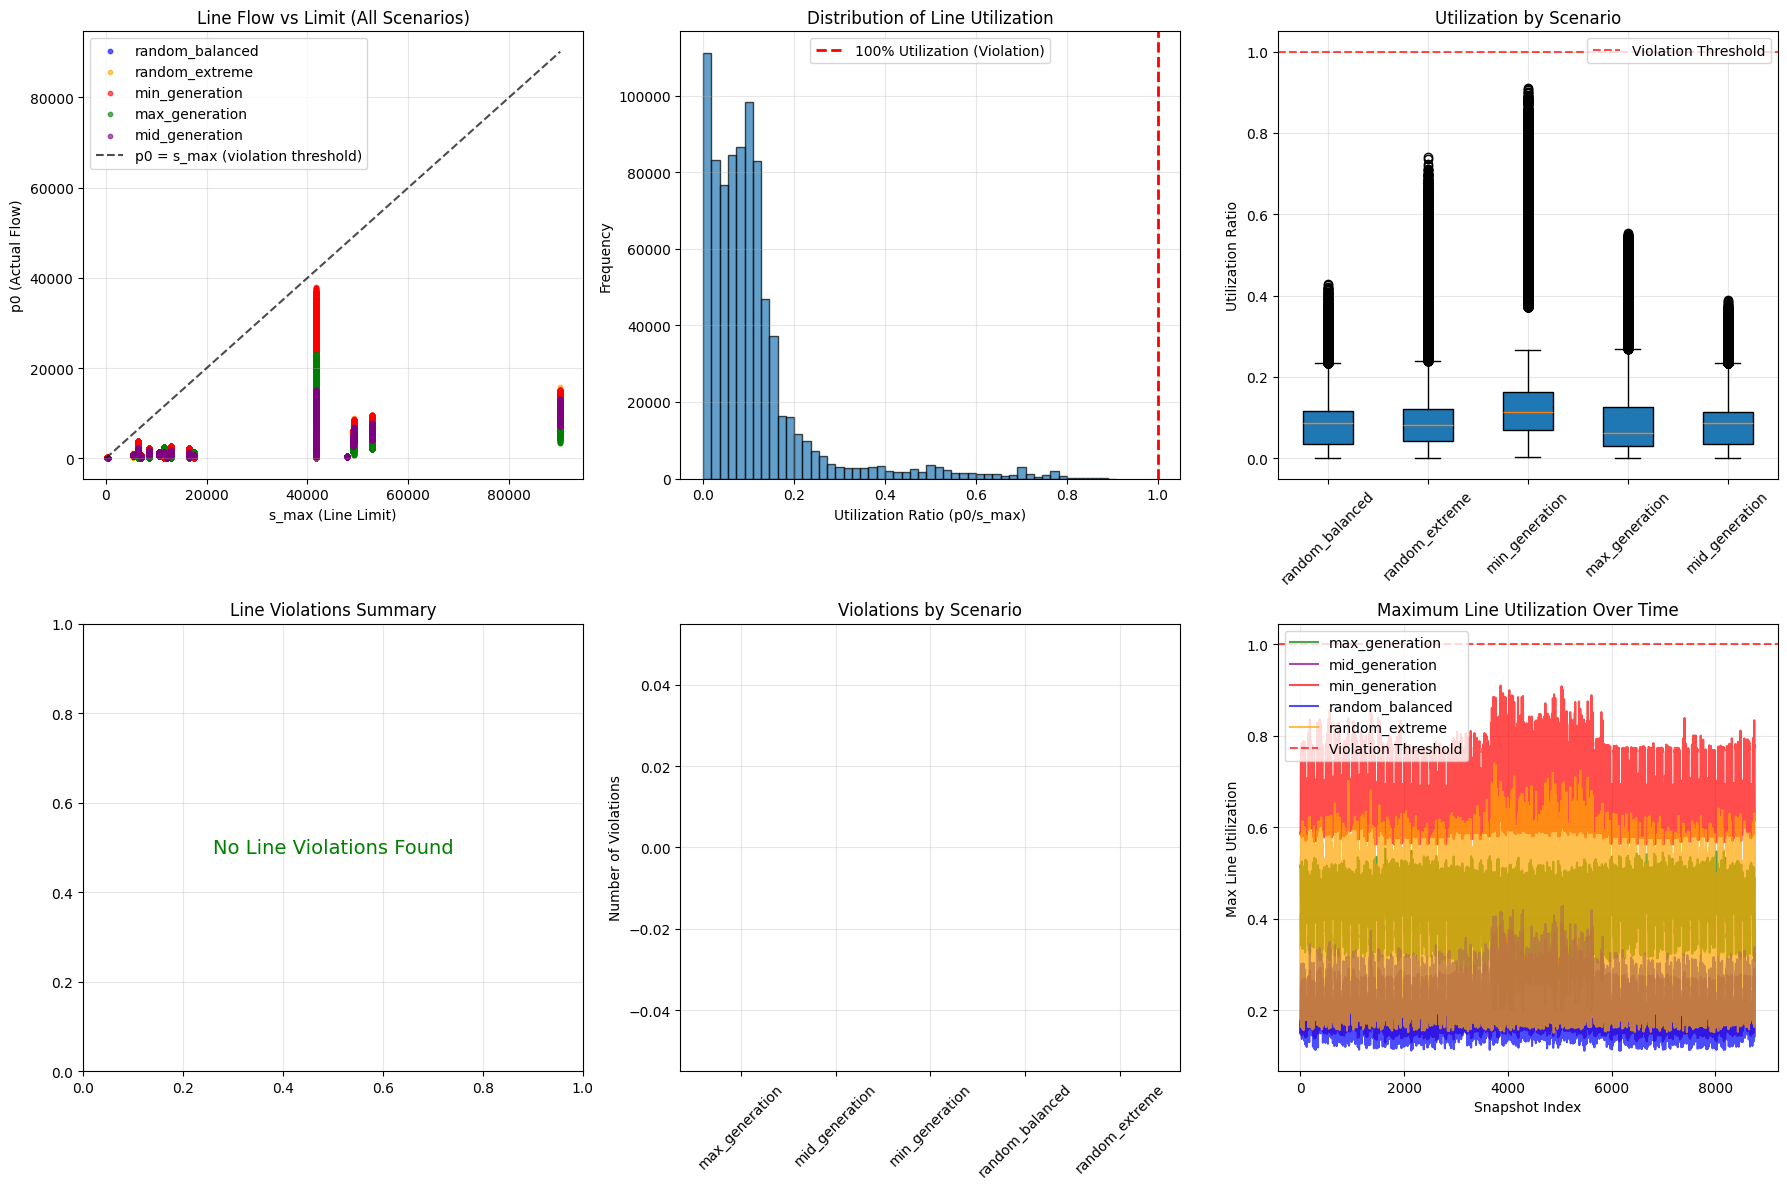

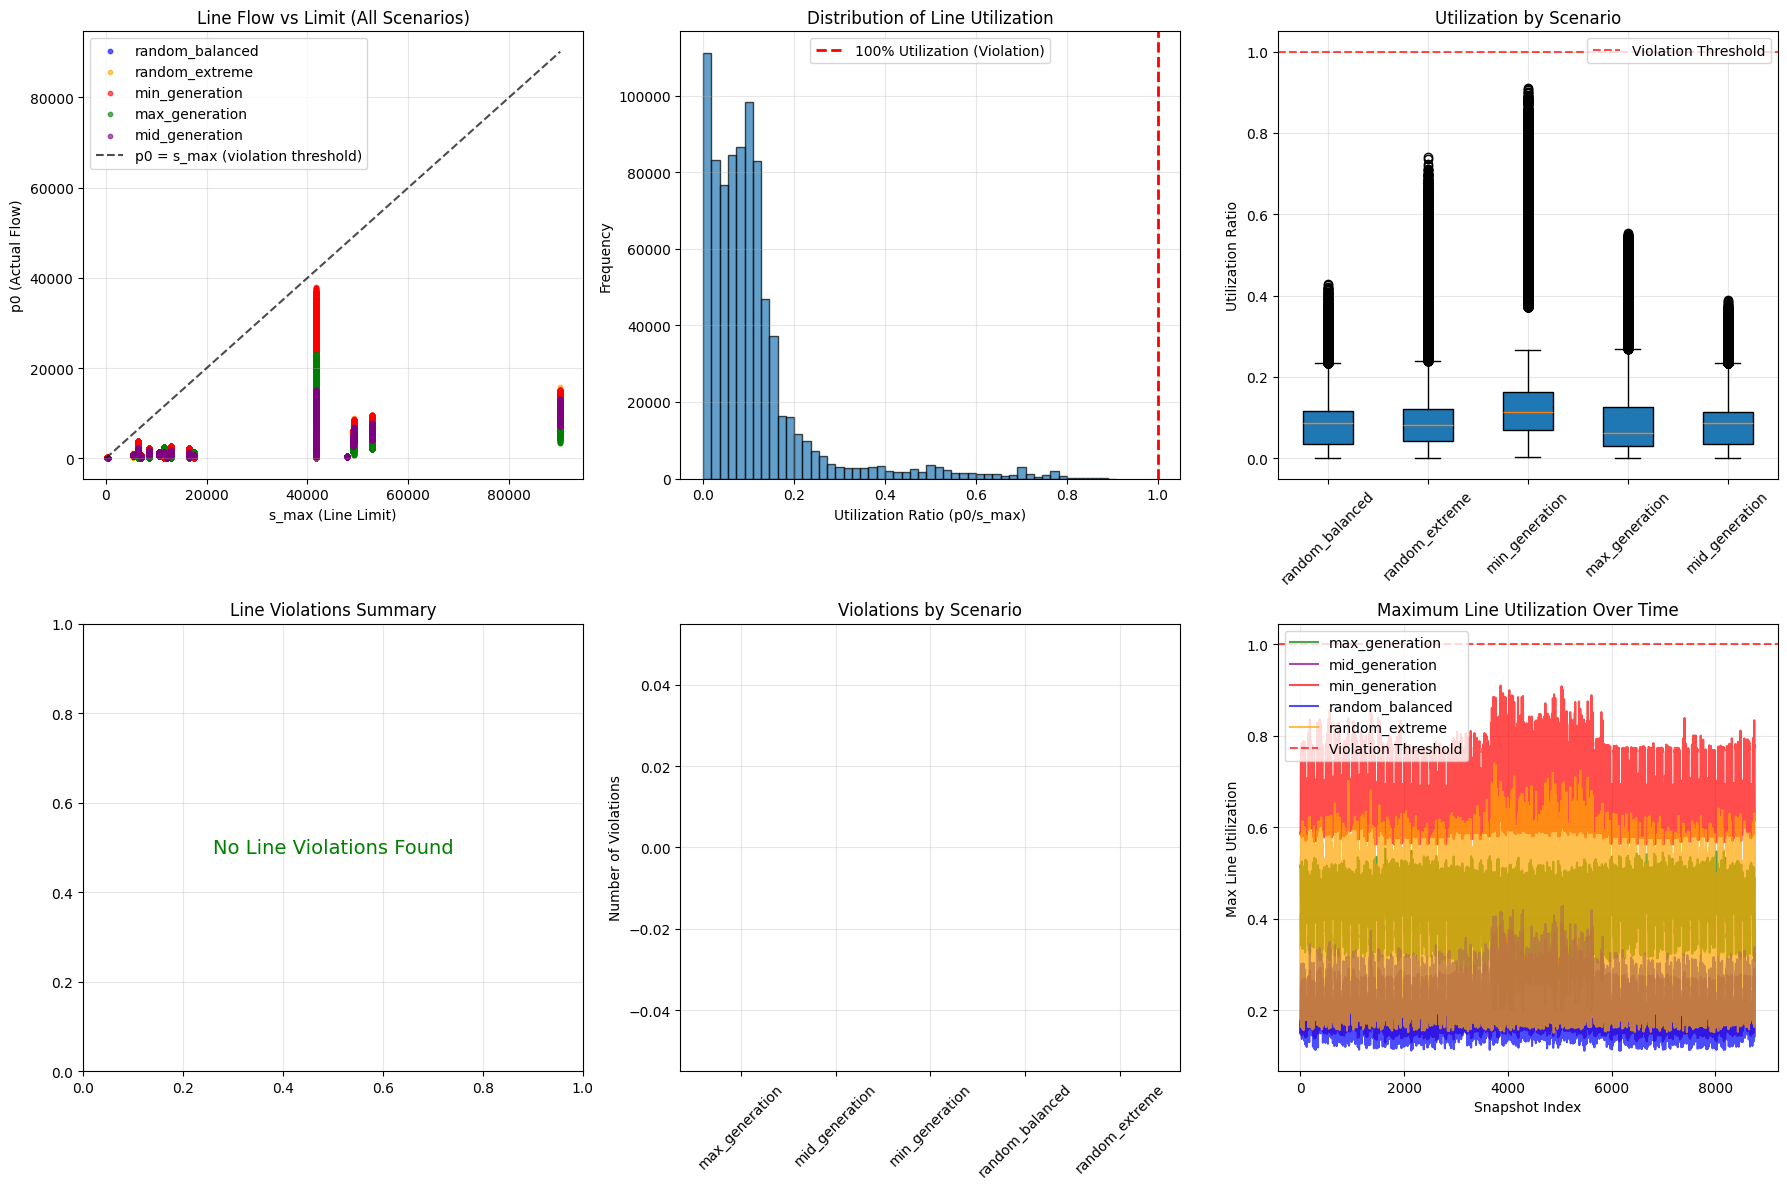

In [38]:
line_data = collect_line_flow_data(network_file_path)
print_line_flow_summary(line_data)
plot_line_flow_analysis(line_data)

In [ ]:
#below is what i called to get full_year_analysis.csv
seed = 42  # Define seed variable first
set_all_seeds(seed)
gdrive_base = './'  # or '/workspace/'
network_file_path = os.path.join(gdrive_base, "networks_1_year_connected", "elec_s_10_ec_lc1.0_1h.nc")
results = analyze_line_violations_vs_objective(
    network_file_path, 
    save_results=True,
    output_dir="./violation_analysis_results",
    run_name="full_year_analysis"
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from datetime import datetime

def analyze_line_violations_vs_objective(network_file, test_snapshots=None, seed=42, 
                                       save_results=True, output_dir="./results", 
                                       run_name=None, **env_kwargs):
    """
    Analyze correlation between line constraint violations and objective function values.
    
    This will help determine if line violations naturally correlate with poor objective
    values, potentially justifying their omission from constraint checking.
    
    Parameters:
    -----------
    save_results : bool
        Whether to save results at the end
    output_dir : str
        Directory to save results
    run_name : str
        Name for this run (will use timestamp if None)
    """
    
    # Create environment
    env = EnvDispatchConstr(
        network_file=network_file, 
        no_convergence_lpf_penalty=100,
        reward_scale_factor=1,
        seed=seed,
        **env_kwargs
    )
    
    # If no test snapshots specified, use all snapshots
    if test_snapshots is None:
        test_snapshots = env.network.snapshots
    
    results = []
    
    print(f"Testing {len(test_snapshots)} snapshots...")
    
    for i, snapshot in enumerate(test_snapshots):
        try:
            # Reset environment
            env.reset(seed=seed + i)
            env.snapshot_idx = env.network.snapshots.get_loc(snapshot)
            
            # Test different action scenarios
            scenarios = {
            'random_balanced': np.random.RandomState(seed + i).uniform(0.4, 0.6, env.action_space.shape[0]),
            'random_extreme': np.random.RandomState(seed + i*2).choice([0.1, 0.9], env.action_space.shape[0]),
            'min_generation': np.zeros(env.action_space.shape[0]),      # All generators at minimum
            'max_generation': np.ones(env.action_space.shape[0]),       # All generators at maximum
            'balanced_midpoint': np.full(env.action_space.shape[0], 0.5) # All at midpoint
        }
            
            for scenario_name, action in scenarios.items():
                try:
                    # Take action
                    env.take_action(action)
                    
                    # Run power flow
                    current_snapshot = env.network.snapshots[env.snapshot_idx]
                    env.network.lpf(current_snapshot, skip_pre=True)
                    
                    # Calculate objective value
                    obj_value = env.evaluate_objective_direct(current_snapshot)
                    
                    # Get constraint violations
                    _, constraint_results = env.calculate_reward_no_penalty()
                    
                    # Extract line violations specifically
                    line_start_idx = 2 * env.n_slack
                    line_end_idx = line_start_idx + env.n_lines
                    line_violations = constraint_results[line_start_idx:line_end_idx]
                    
                    # Calculate line violation metrics
                    max_line_violation = np.max(line_violations) if len(line_violations) > 0 else 0
                    total_line_violation = np.sum(line_violations) if len(line_violations) > 0 else 0
                    n_violated_lines = np.sum(line_violations > 0) if len(line_violations) > 0 else 0
                    
                    # Store results
                    results.append({
                        'snapshot': snapshot,
                        'scenario': scenario_name,
                        'objective_value': obj_value,
                        'max_line_violation': max_line_violation,
                        'total_line_violation': total_line_violation,
                        'n_violated_lines': n_violated_lines,
                        'any_line_violated': max_line_violation > 0,
                        'total_constraint_violation': np.sum(constraint_results),
                        'max_constraint_violation': np.max(constraint_results)
                    })
                    
                except Exception as e:
                    print(f"Failed scenario {scenario_name} at snapshot {i}: {e}")
                    continue
                    
        except Exception as e:
            print(f"Failed snapshot {i}: {e}")
            continue
            
        if (i + 1) % 50 == 0:
            print(f"Completed {i + 1}/{len(test_snapshots)} snapshots...")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results if requested
    if save_results and len(results_df) > 0:
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Generate filename
        if run_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            run_name = f"line_violation_analysis_{timestamp}"
        
        # Save in multiple formats for redundancy
        csv_path = os.path.join(output_dir, f"{run_name}.csv")
        pickle_path = os.path.join(output_dir, f"{run_name}.pkl")
        
        try:
            # Save as CSV
            results_df.to_csv(csv_path, index=False)
            print(f"Results saved to CSV: {csv_path}")
            
            # Save as pickle (preserves data types better)
            with open(pickle_path, 'wb') as f:
                pickle.dump(results_df, f)
            print(f"Results saved to pickle: {pickle_path}")
            
            # Also save metadata
            metadata = {
                'network_file': network_file,
                'n_snapshots': len(test_snapshots),
                'n_results': len(results_df),
                'seed': seed,
                'timestamp': datetime.now().isoformat(),
                'env_kwargs': env_kwargs
            }
            
            metadata_path = os.path.join(output_dir, f"{run_name}_metadata.pkl")
            with open(metadata_path, 'wb') as f:
                pickle.dump(metadata, f)
            print(f"Metadata saved to: {metadata_path}")
            
        except Exception as e:
            print(f"Warning: Could not save results: {e}")
    
    return results_df

def load_saved_results(filepath):
    """
    Load previously saved results from either CSV or pickle file
    """
    if filepath.endswith('.csv'):
        return pd.read_csv(filepath)
    elif filepath.endswith('.pkl'):
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    else:
        raise ValueError("File must be .csv or .pkl")

def plot_violation_correlation(results_df):
    """Plot correlation between line violations and objective values"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Scatter plot: Objective vs Max Line Violation
    ax1 = axes[0, 0]
    colors = {'random_balanced': 'blue', 'random_extreme': 'orange', 
              'min_generation': 'red', 'max_generation': 'green', 'balanced_midpoint': 'purple'}
    
    for scenario in results_df['scenario'].unique():
        data = results_df[results_df['scenario'] == scenario]
        ax1.scatter(data['max_line_violation'], data['objective_value'], 
                   alpha=0.6, label=scenario, color=colors.get(scenario, 'gray'))
    
    ax1.set_xlabel('Max Line Violation')
    ax1.set_ylabel('Objective Value')
    ax1.set_title('Objective Value vs Max Line Violation')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plot: Objective values by violation status
    ax2 = axes[0, 1]
    violated_data = results_df[results_df['any_line_violated']]['objective_value']
    not_violated_data = results_df[~results_df['any_line_violated']]['objective_value']
    
    if len(violated_data) > 0 and len(not_violated_data) > 0:
        ax2.boxplot([not_violated_data, violated_data], 
                    labels=['No Line Violations', 'Line Violations'])
        ax2.set_ylabel('Objective Value')
        ax2.set_title('Objective Distribution by Line Violation Status')
        ax2.grid(True, alpha=0.3)
    
    # 3. Histogram of objective values, split by violation
    ax3 = axes[1, 0]
    if len(not_violated_data) > 0:
        ax3.hist(not_violated_data, alpha=0.7, label='No Violations', bins=30, density=True)
    if len(violated_data) > 0:
        ax3.hist(violated_data, alpha=0.7, label='With Violations', bins=30, density=True)
    ax3.set_xlabel('Objective Value')
    ax3.set_ylabel('Density')
    ax3.set_title('Objective Value Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Correlation heatmap of all violation types
    ax4 = axes[1, 1]
    corr_cols = ['objective_value', 'max_line_violation', 'total_line_violation', 
                 'n_violated_lines', 'total_constraint_violation']
    corr_matrix = results_df[corr_cols].corr()
    
    im = ax4.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
    ax4.set_xticks(range(len(corr_cols)))
    ax4.set_yticks(range(len(corr_cols)))
    ax4.set_xticklabels([col.replace('_', '\n') for col in corr_cols], rotation=45)
    ax4.set_yticklabels([col.replace('_', '\n') for col in corr_cols])
    ax4.set_title('Correlation Matrix')
    
    # Add correlation values to heatmap
    for i in range(len(corr_cols)):
        for j in range(len(corr_cols)):
            text = ax4.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=ax4)
    plt.tight_layout()
    plt.show()
    
    return fig

def print_violation_statistics(results_df):
    """Print summary statistics about violations and objectives"""
    
    print("=== LINE VIOLATION ANALYSIS ===\n")
    
    # Basic statistics
    total_cases = len(results_df)
    violated_cases = results_df['any_line_violated'].sum()
    violation_rate = violated_cases / total_cases * 100
    
    print(f"Total test cases: {total_cases}")
    print(f"Cases with line violations: {violated_cases} ({violation_rate:.1f}%)")
    print(f"Cases without line violations: {total_cases - violated_cases} ({100-violation_rate:.1f}%)\n")
    
    # Objective value comparison
    violated_obj = results_df[results_df['any_line_violated']]['objective_value']
    clean_obj = results_df[~results_df['any_line_violated']]['objective_value']
    
    if len(violated_obj) > 0 and len(clean_obj) > 0:
        print("OBJECTIVE VALUE COMPARISON:")
        print(f"Without line violations - Mean: {clean_obj.mean():.2f}, Std: {clean_obj.std():.2f}")
        print(f"With line violations    - Mean: {violated_obj.mean():.2f}, Std: {violated_obj.std():.2f}")
        print(f"Difference in means: {violated_obj.mean() - clean_obj.mean():.2f}")
        
        # Statistical test
        from scipy import stats
        t_stat, p_value = stats.ttest_ind(violated_obj, clean_obj)
        print(f"T-test p-value: {p_value:.4f}\n")
        
        # Correlation analysis
        corr_max = results_df['objective_value'].corr(results_df['max_line_violation'])
        corr_total = results_df['objective_value'].corr(results_df['total_line_violation'])
        
        print("CORRELATION WITH OBJECTIVE:")
        print(f"Max line violation: {corr_max:.3f}")
        print(f"Total line violation: {corr_total:.3f}\n")
        
        # Percentile analysis
        violated_percentile = (violated_obj > clean_obj.median()).mean() * 100
        print(f"% of violation cases above median of clean cases: {violated_percentile:.1f}%")
        
        worst_10_percent_threshold = clean_obj.quantile(0.9)
        violation_in_worst_10 = (violated_obj > worst_10_percent_threshold).mean() * 100
        print(f"% of violation cases in worst 10% of clean cases: {violation_in_worst_10:.1f}%")
    
    # By scenario analysis
    print("\nBY SCENARIO:")
    scenario_stats = results_df.groupby('scenario').agg({
        'any_line_violated': ['count', 'sum', 'mean'],
        'objective_value': ['mean', 'std'],
        'max_line_violation': 'mean'
    }).round(3)
    print(scenario_stats)

# Example usage with automatic saving:
# results = analyze_line_violations_vs_objective(
#     network_file_path, 
#     save_results=True,
#     output_dir="./violation_analysis_results",
#     run_name="full_year_analysis"
# )
# 
# # Or to load previously saved results:
# # results = load_saved_results("./violation_analysis_results/full_year_analysis.pkl")
# 
# print_violation_statistics(results)
# plot_violation_correlation(results)